In [1]:
#****************************** PRE-PROCESSING PORTION ******************************
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
import imageio

from os import walk
import re
import fnmatch

from numpy.random import seed
#seed for random number generator for repro
seedVal = 24
seed(seedVal)
from tensorflow import set_random_seed
set_random_seed(seedVal)

import numpy as np
from keras import backend
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras.datasets import mnist
from matplotlib import pyplot as plt


# to change backend: open anaconda promp and type: set "KERAS_BACKEND"=<backend_name>
print(backend._BACKEND)

Using TensorFlow backend.


tensorflow


In [4]:
#CONVERT RGB IMAGES TO GREYSCALE
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [5]:
#ITERATE OVER FILES IN FULL AND PARTIAL DIRECTORIES. EXTRACT AREA OF INTEREST AND PERSIST.
#REUSABLE FILE HELPER
def GetFilesFromDirectory(directory, includes):
    files = []
    includes = r'|'.join([fnmatch.translate(x) for x in includes])
    for (dirpath, dirnames, filenames) in walk(directory):
        files.extend(filenames)
        files = [f for f in files if re.match(includes, f)]
        break
    return files

In [6]:
def LoadImagesIntoArray(directory, includes):
    fullFiles = GetFilesFromDirectory(directory, includes)
    fullImageArray = []
    for f in fullFiles: 
        image = mpimg.imread(directory+'/'+f)
        fullImageArray.append(image)
    return fullImageArray

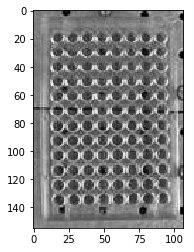

In [5]:
#LOAD IN TEMPLATE IMAGE AND CONVERT TO GREYSCALE
template = mpimg.imread('//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/Template/PlateTemplate.jpg')     
grayTemplate = rgb2gray(template)    
grayTemplate = grayTemplate - grayTemplate.mean()
plt.imshow(grayTemplate, cmap = plt.get_cmap('gray'))
plt.show()

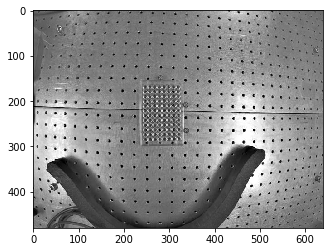

In [6]:
#LOAD IN FIRST IMAGE AND CONVERT TO GREYSCALE
testImg = mpimg.imread('//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/Template/PlateTemplateFull.jpg')     
grayTestImg = rgb2gray(testImg)
grayTestImg = grayTestImg - grayTestImg.mean()
plt.imshow(grayTestImg, cmap = plt.get_cmap('gray'))
plt.show()

In [7]:
#PERFORM CROSS CORRELATION TO FIND PLATE IN IMAGE
corr = signal.correlate2d(grayTestImg, grayTemplate, boundary='symm', mode='same')

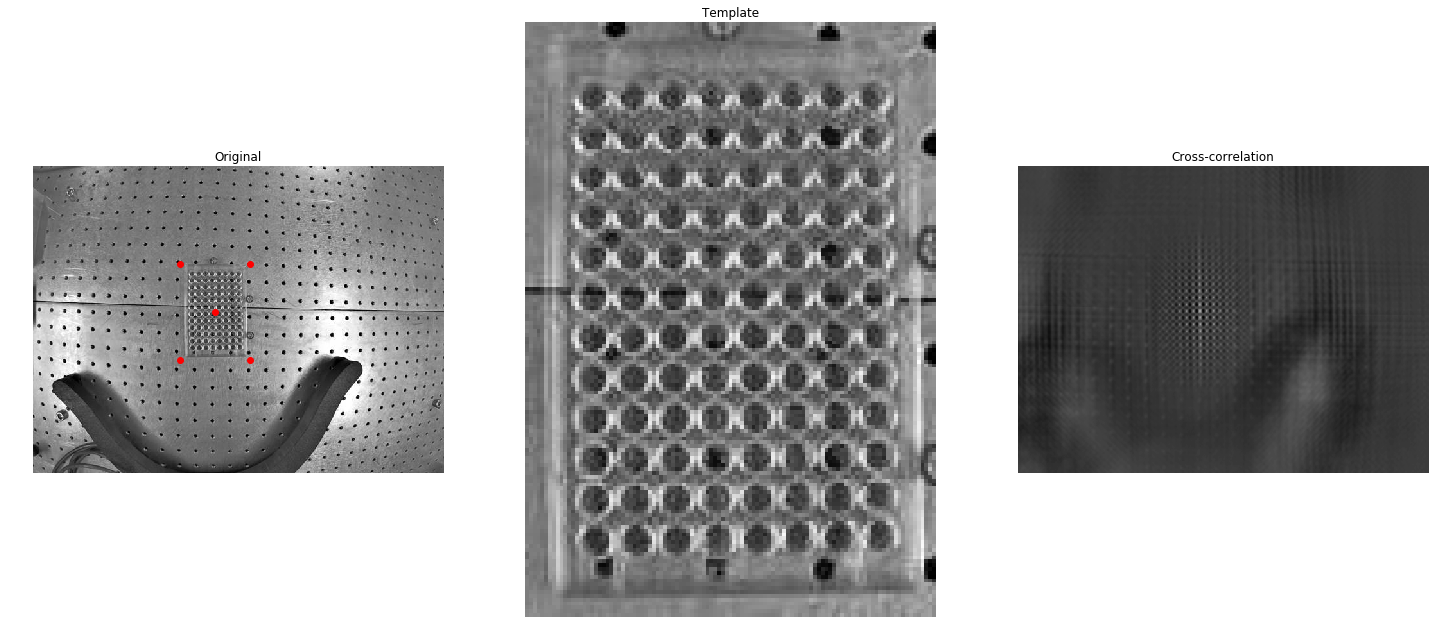

In [8]:
#FIND INDEX OF HIGHEST CORRELATION
y, x = np.unravel_index(np.argmax(corr), corr.shape) # find the match
fig, (ax_orig, ax_template, ax_corr) = plt.subplots(1, 3, figsize=(25,25))
ax_orig.imshow(grayTestImg, cmap='gray')

# TOP LEFT, TOP RIGHT, BOTTOM RIGHT, BOTTOM LEFT COORDINATES FOR AREA OF INTEREST
_tlx = x-55
_tly = y-75

_trx = x+55
_try = y-75

_brx = x+55
_bry = y+75

_blx = x-55
_bly = y+75

#PLOT STUFF FOR DOUBLE CHECKING
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_template.imshow(grayTemplate, cmap='gray')
ax_template.set_title('Template')
ax_template.set_axis_off()
ax_corr.imshow(corr, cmap='gray')
ax_corr.set_title('Cross-correlation')
ax_corr.set_axis_off()
ax_orig.plot(x, y, 'ro')
#PLOT POINTS TO SHOW AREA OF INTEREST
ax_orig.plot(_tlx, _tly, 'ro')
ax_orig.plot(_trx, _try, 'ro')
ax_orig.plot(_brx, _bry, 'ro')
ax_orig.plot(_blx, _bly, 'ro')

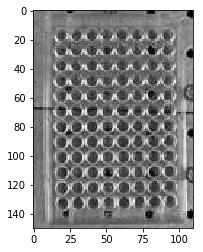

In [9]:
#EXTRACT AREA OF INTEREST FROM ORIGINAL IMAGE
foundPlateImg = np.copy(grayTestImg[_tly:_bry,_tlx:_brx])
plt.imshow(foundPlateImg, cmap = plt.get_cmap('gray'))

In [2]:
includes = ['*.png','*.jpg']

fullPlateDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/Full'
extractedFullPlateDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/ExtractedFull'

notFullPlateDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/NotFull'
extractedNotFullPlateDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/ExtractedNotFull'

In [10]:
fullFiles = GetFilesFromDirectory(fullPlateDir,includes)
counter = 0

for fName in fullFiles:
    counter = counter+1
    tempImage = mpimg.imread(fullPlateDir+'/'+fName)
    subImage = np.copy(tempImage[_tly:_bry,_tlx:_brx])
    imageio.imwrite(extractedFullPlateDir + "/" + 'ExtractedFullImage_' + str(counter) + '.png', subImage)

notFullFiles = GetFilesFromDirectory(notFullPlateDir, includes)
counter = 0

for fName in notFullFiles:
    counter = counter+1
    tempImage = mpimg.imread(notFullPlateDir+'/'+fName)
    subImage = np.copy(tempImage[_tly:_bry,_tlx:_brx])
    imageio.imwrite(extractedNotFullPlateDir + "/" + 'ExtractedNotFullImage_' + str(counter) + '.png', subImage)

In [11]:
#****************************** DEEP CONV NET PORTION ******************************

(212, 150, 110, 3)
(212,)


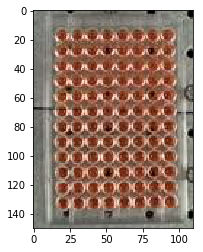

In [7]:

# Load train and test sets of full vs non-full plates
includes = ['*.png','*.jpg']
#LOAD FULL PLATE IMAGES INTO ARRAY AND GENERATE LABELS  
fullImageArray = LoadImagesIntoArray(extractedFullPlateDir, includes)
fullPlateLabels = np.ones(len(fullImageArray))
#LOAD NOT FULL PLATE IMAGES INTO ARRAY AND GENERATE LABELS
notFullImageArray = LoadImagesIntoArray(extractedNotFullPlateDir, includes)
notFullPlateLabels = np.zeros(len(notFullImageArray))

#COMBINE FULL AND NOT FULL PLATE IMAGES
fullImageArray.extend(notFullImageArray)
allImages = np.array(fullImageArray)
allLabels = np.append(fullPlateLabels, notFullPlateLabels)

#allImages = allImages[...,2]
#print(allImages.shape)
#allImages = allImages.reshape(allImages.shape[0], allImages.shape[1], allImages.shape[2], 1)

print(allImages.shape)
print(allLabels.shape)

#plt.imshow((allImages[0])[:,:,0], cmap = plt.get_cmap('gray'))
plt.imshow(allImages[0])

In [14]:
#Cast all pixel values to float, then divide by max pixel value to get values between 0 and 1
data_train_casted = allImages.astype('float32')
data_train_casted /= 255

In [15]:
#Index labels using one-hot encoding. We know there are 2 class labels: full plate, partial plate
labels_train_encoded = np_utils.to_categorical(allLabels, 2)

print(labels_train_encoded.shape)


(212, 2)


In [16]:


#get the input image dims
imageDim1 = allImages.shape[1]
imageDim2 = allImages.shape[2]
imageDim3 = allImages.shape[3]

print(imageDim1)
print(imageDim2)
print(imageDim3)

150
110
3


In [17]:



#start defining learning model
model = Sequential()
model.add(Convolution2D(filters=32,kernel_size=(5, 5), activation='relu', input_shape=(imageDim1,imageDim2,imageDim3), data_format='channels_last'))

#Add additional layers to model
model.add(Convolution2D(filters=32,kernel_size=(5, 5), activation='relu', input_shape=(imageDim1,imageDim2,imageDim3), data_format='channels_last'))
#Pool weights by max within the sliding window 2,2. Reduces model parameter count
model.add(MaxPooling2D(pool_size=(2,2)))

#Drop out is a method for regularizing our model in order to prevent overfitting
model.add(Dropout(0.25))
#Flatten input
#weights from the Convolution layers must be flattened (made 1-dimensional) 
#before passing them to the fully connected Dense layer.
model.add(Flatten())
#add fully connected layer with relu activation function
model.add(Dense(128, activation='relu'))
#Dropout to prevent overfitting
model.add(Dropout(0.5))
#add another fully connected layer with activation function softmax to result in output being between 0 and 1
model.add(Dense(2, activation='softmax'))




In [18]:
# compile model with loss function and optimizer approach
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
#fit data. Batch size is number of samples per gradient update/step.
#epoch = total number of iterations on the data
model.fit(data_train_casted, labels_train_encoded, batch_size=16, epochs=14, verbose=1, validation_split=.1)

Train on 190 samples, validate on 22 samples
Epoch 1/14
190/190 [==============================] - 14s 75ms/step - loss: 0.0459 - acc: 0.9842 - val_loss: 0.1429 - val_acc: 0.9091
Epoch 2/14
190/190 [==============================] - 14s 74ms/step - loss: 0.0457 - acc: 0.9842 - val_loss: 0.2090 - val_acc: 0.9091
Epoch 3/14
190/190 [==============================] - 14s 75ms/step - loss: 0.0250 - acc: 0.9947 - val_loss: 0.1097 - val_acc: 0.9091
Epoch 4/14
190/190 [==============================] - 14s 75ms/step - loss: 0.0199 - acc: 0.9895 - val_loss: 0.1328 - val_acc: 0.9091
Epoch 5/14
190/190 [==============================] - 14s 75ms/step - loss: 0.0279 - acc: 0.9947 - val_loss: 0.4029 - val_acc: 0.8182
Epoch 6/14
190/190 [==============================] - 15s 77ms/step - loss: 0.0347 - acc: 0.9895 - val_loss: 0.1507 - val_acc: 0.9091
Epoch 7/14
190/190 [==============================] - 15s 78ms/step - loss: 0.0168 - acc: 0.9947 - val_loss: 0.1673 - val_acc: 0.9091
Epoch 8/14
190/19

In [41]:
#save model 
model.save('FullPlateVisionNet.h5')

In [42]:
#load model
model = load_model('FullPlateVisionNet.h5')

PREDICTED: 0

IMAGE ANALYZED: 


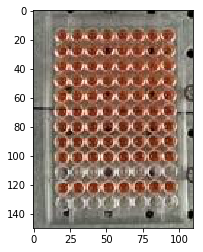

In [45]:
#LOAD ALL IMAGED INTO MEMORY FOR PREDICTION
#testDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/ExtractedFull/ExtractedFullImage_30.png'
testDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/ExtractedNotFull/ExtractedNotFullImage_123.png'
testImage = mpimg.imread(testDir)
#testImage = testImage[:,:,2]
#testImage = testImage.reshape(testImage.shape[0], testImage.shape[1], 1)
predictionSet = np.array([testImage])
predictionSet = predictionSet.astype('float32')
predictionSet /= 255

predictions = model.predict(x=predictionSet)
predicted = predictions.argmax()
print('PREDICTED: ' + str(predicted))
print('')
print('IMAGE ANALYZED: ')
plt.imshow(testImage)
    
#plt.imshow(testImage[:,:,0], cmap = plt.get_cmap('gray'))

In [8]:

#pull red channel from data
allRedImages = allImages[...,2]
allRedImages = allRedImages.reshape(allRedImages.shape[0], allRedImages.shape[1], allRedImages.shape[2], 1)
#Cast all pixel values to float, then divide by max pixel value to get values between 0 and 1
data_train_casted = allRedImages.astype('float32')
data_train_casted /= 255


#get the input image dims
imageDim1 = allRedImages.shape[1]
imageDim2 = allRedImages.shape[2]
imageDim3 = allRedImages.shape[3]
print(imageDim1)
print(imageDim2)
print(imageDim3)


150
110
1


In [20]:
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

input_img = Input(shape = (imageDim1, imageDim2, imageDim3))

#encoder
conv1 = Conv2D(filters=4, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(imageDim1,imageDim2,imageDim3), data_format='channels_last')(input_img)
pool1 = MaxPooling2D(pool_size=(3, 5))(conv1)
#conv2 = Conv2D(filters=64,kernel_size=(5, 5), activation='relu', padding='same')(pool1)
#pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#compressed latent space
conv3 = Conv2D(filters=4, kernel_size=(5, 5), activation='relu', padding='same')(pool1) 

#decoder
#conv4 = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(conv3) 
#up1 = UpSampling2D((2,2))(conv4)
conv5 = Conv2D(filters=4, kernel_size=(5, 5), activation='relu', padding='same')(conv3) 
up2 = UpSampling2D((3,5))(conv5)
decoded = Conv2D(filters=1, kernel_size=(imageDim1, imageDim2), activation='sigmoid', padding='same')(up2)


autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 150, 110, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 150, 110, 4)       104       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 22, 4)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 50, 22, 4)         404       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 50, 22, 4)         404       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 150, 110, 4)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 150, 110, 1)       66001     
Total para

In [ ]:
autoencoder.fit(x=data_train_casted, y=data_train_casted, batch_size=4, epochs=10, verbose=1, validation_split=.1)

Train on 190 samples, validate on 22 samples
Epoch 1/10
190/190 [==============================] - 718s 4s/step - loss: 0.0268 - acc: 0.0064 - val_loss: 0.0292 - val_acc: 0.0065
Epoch 2/10
190/190 [==============================] - 698s 4s/step - loss: 0.0267 - acc: 0.0064 - val_loss: 0.0291 - val_acc: 0.0065
Epoch 3/10
190/190 [==============================] - 690s 4s/step - loss: 0.0265 - acc: 0.0064 - val_loss: 0.0286 - val_acc: 0.0065
Epoch 4/10
190/190 [==============================] - 691s 4s/step - loss: 0.0221 - acc: 0.0064 - val_loss: 0.0163 - val_acc: 0.0065
Epoch 5/10
190/190 [==============================] - 692s 4s/step - loss: 0.0147 - acc: 0.0064 - val_loss: 0.0144 - val_acc: 0.0065
Epoch 6/10
172/190 [==========================>...] - ETA: 1:02 - loss: 0.0127 - acc: 0.0065

(150, 110)
IMAGE ANALYZED: 


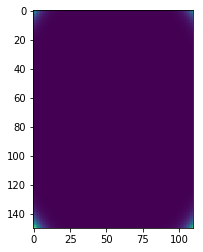

In [30]:

testDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/ExtractedFull/ExtractedFullImage_3.png'
#testDir = '//altair/shared/Automation/Projects/MultiDropMachineVision/TrainingImages/ExtractedNotFull/ExtractedNotFullImage_55.png'
testImage = mpimg.imread(testDir)
#pull red channel from data
testImage = testImage[...,2]
testImage = testImage.reshape(testImage.shape[0], testImage.shape[1], 1)

predictionSet = np.array([testImage])
predictionSet = predictionSet.astype('float32')
predictionSet /= 255

predictions = autoencoder.predict(x=predictionSet)
predicted = (predictions[0])[:,:,0]
print(predicted.shape)
print('IMAGE ANALYZED: ')
plt.imshow(predicted)